<p style="color:Blue"><font size="6">Stochastic Diffusion Search</font></p>

<p ><font size="4">An approach to solve the Curse of Dimensionality in Data Science using SDS Feature Selection</font></p> 

<p ><font size="3">This is a project done for the Optimization course of The Informatics Department at AUTh.</font></p>


<p ><font size="3"> The theory behind the algorithm is originally published <a href="https://www.researchgate.net/publication/226082976_Stochastic_Diffusion_Search_Partial_Function_Evaluation_In_Swarm_Intelligence_Dynamic_Optimisation">here</a>.</font></p>

### Importing necessary libraries

In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
import time

### Creating our estimators

In [10]:
logReg=LogisticRegression(C=2)
decClf=DecisionTreeClassifier(max_depth=5, min_samples_split=4)
rfc=RandomForestClassifier()

In [11]:
estimators=[rfc,logReg,decClf] 

_____
## 1) Initialization Phase - Hypothesis Selection 
_____

### Function to randomly select an agents hypothesis.

In [12]:
'''
Below function returns an agent, which is hypothesis, and its corresponding binary array.
1 indicates inclusion of corresponding feature and 0 indicates exclusion of the feature.
lowerLim indicates minimum number of features, whereas; upperLim indicated max no of features to beincluded in an agent.
'''
def agent(arryX,lowerLim,upperLim):
        if lowerLim<0 or upperLim>arryX.shape[1]:
            print('recall function with appropriate limits')
        else:
            randomNoFeatures=np.random.randint(lowerLim,upperLim,size=1)[0] #generating a random number
            zeroArry=np.zeros(arryX.shape[1]-randomNoFeatures, dtype='int') #zero array 
            oneArry=np.ones(randomNoFeatures, dtype='int')   #one array
            fArry=np.concatenate((zeroArry,oneArry), axis=0) #concatinating zero and one array
            np.random.shuffle(fArry) #shuffling fArray
            fIndex=np.where(fArry==1)[0]
            agentArry=arryX[:,fIndex] #generating feature subset from origanal dataset
            return fArry,agentArry #returns array of 0s and 1s of features selected, and the new agent's dataset

### Function to initialize all agents' hypotheses.

In [13]:
'''
Below function generates required number of agents that are to be deployed on search space. 
All the agents and corresponding binary feature array are stored and returned as a list.
'''
def agentsInitiation(arryX,numAgents,lowerLim,upperLim):
        agents=[]
        agentFIndex=[]
        agentStatus=['active']*numAgents #create a status list of 'active' agents
        for i in range(0,numAgents):
            fArry,agentArry=agent(arryX,lowerLim,upperLim) #generating a single agent
            agentFIndex.append(fArry) #appending its binary feature array to agentFIndex (list to store each agent's 0-1 array)
            agents.append(agentArry) #appending the agent to the agents list (list to store each agent's dataset)
        return agents,agentFIndex,agentStatus #return the 2 lists above, and a list of 'active' statuses

### Function to calculate the score of an agent's hypothesis 

<p style="color:Red"><font size="2">TODO: Create actual ensemble - This is just averaging scores</font></p>

In [14]:
'''
'Score' function fits each model to the agent's training data and then evaluates the score on test data. 
The output is the average score of three estimators. We calculate the average so we can have an ensemble of model predictions,
and thus not be biased toward one specific model's predictions.
'''
def score(estimators,arryX,arrY):
        X_train,X_test,y_train,y_test=train_test_split(arryX,arrY,random_state=0)
        scores=[]
        for i in range(len(estimators)):
            estimators[i].fit(X_train,y_train) #fitting the ith estimator to the training data of an agent
            scores.append(estimators[i].score(X_test,y_test)) #evaluating the score on the test data
        return sum(scores)/len(scores)

### Function to calculate the score of all agents and save them

In [15]:
#below function calculates score for each agents and appends the score to the agentScores list
def agentClfscores(estimators,agents,arrY):
    agentScores=[]
    for agent in agents:
        agentscore=score(estimators,agent,arrY)
        agentScores.append(agentScores)
    return agentScores #returns a list that captures agents' scores

_____
## 2) Testing Phase - Turn agents into active ones or inactive ones based on partial evaluation

## 3) Diffusion Phase - Information diffusion between agents
____

### Function that carries out the testing and diffusion phase

In [16]:
'''
Below function carries out test and diffusion phase among the agents initialized above. 
The function returns agents and their corresponding scores, binary feature arrays, and staus after numIterations.
'''

def SDSFS(arryX,arrY,estimators,numIterations,numAgents,lowerLim,upperLim):
    agents,agentFIndex,agentStatus=agentsInitiation(arryX,numAgents,lowerLim,upperLim) #agents' datasets, 0-1 arrays, active' status
    agentScores=agentClfscores(estimators,agents,arrY) # list of agents' scores
    niters=0
    while niters<numIterations: # um of iterations that testing and diffusion will happen
        print("Iter: " + str(niters))
        #Testing phase
        for i in range(len(agents)):
            rndmId=np.random.randint(len(agents),size=1)[0]
            if agentScores[i]>agentScores[rndmId]: # if ith agents has better score than a random agent, then become 'active' or 'happy' 
                agentStatus[i]='active' 
                
            else:                                  # else if ith agent has worse score than a random agent, become 'inactive' or 'unhappy'
                agentStatus[i]='inactive'
                
        #Diffusion phase    
        for i in range(len(agents)):
# ========= if ith agent is 'unhappy' =========
            if agentStatus[i]=='inactive': 
                rndmId2=np.random.randint(len(agents),size=1)[0]
# ============= if random agent is 'happy' =============
                if agentStatus[rndmId2]=='active': 
                    oneIds=np.where(agentFIndex[rndmId2]==1)[0] # find where are the random agent's 1s
                    #print(oneIds)
                    zeroIds=np.where(agentFIndex[rndmId2]==0)[0] # find where are the random agent's 0s
                    rndmId3=np.random.randint(len(oneIds), size=1) # create n1 random number in range [0,numOf1s]
                    rndmId4=np.random.randint(len(zeroIds), size=1) # create n0 random number in range [0,numOf0s]
                    oneZeroId=oneIds[rndmId3] # choose a 1-feature at random (from the random agent's 1s)
                    zeroOneId=zeroIds[rndmId4] # choose a 0-feature at random (from the random agent's 0s)
                    agentFIndex[i]=agentFIndex[rndmId2].copy() # copy the random agent's 0-1 array
                    agentFIndex[i][oneZeroId]=0 # change this specific 1-feature to 0 (mutation)
                    agentFIndex[i][zeroOneId]=1 # change this specific 0-feature to 1 (mutation)
                    fIndex2=np.where(agentFIndex[i]==1)[0] # find where are the ith agent's 1s
                    agents[i]=X[:,fIndex2] # create new dataset for the ith agent
                    agentScores[i]=score(estimators,agents[i],arrY) # compute new score 
# ============= else if random agent is 'unhappy' =============
                else:            
                    agentFIndex[i],agents[i]=agent(arryX,lowerLim,upperLim) # try again with different random combination
                    agentScores[i]=score(estimators,agents[i],arrY) # compute new score  
# ========= else if ith agent is 'happy' ========= 
            else:                           
                rndmId5=np.random.randint(len(agents),size=1)[0]
                # if random agent == ith agent
                if agentStatus[rndmId5]=='active' and (agentFIndex[i]==agentFIndex[rndmId5]).all():
                    agentStatus[i]='inactive' # make ith agent 'inactive' or 'unhappy' (escape local minimal)
                    agentFIndex[i],agents[i]=agent(arryX,lowerLim,upperLim) # try again with different random combination
                    agentScores[i]=score(estimators,agents[i],arrY)
        niters+=1
    return agents,agentFIndex,agentStatus,agentScores
    

<p style="color:Green"><font size="5">Experiments</font></p>

<p style="color:Red"><font size="4">2) Image Pixels</font></p>

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

More info on the dataset can be found <a href="https://www.kaggle.com/zalando-research/fashionmnist">here</a>.</font></p>

In [312]:
df=pd.read_csv('./FashionMNIST/fashion-mnist_train.csv')
df_test=pd.read_csv('./FashionMNIST/fashion-mnist_test.csv')

In [51]:
df.shape #the dataset has 750 features and one class column

(60000, 785)

In [52]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
df['label'].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

## Drop missing values

In [54]:
df.dropna(inplace=True) #deleting any rows with missing values

In [55]:
df.isnull().any().isnull().any() #confirming there are no missing values in the dataframe

False

## Create X and y set

In [56]:
X=np.array(df[list(df.columns[1:])]) 
# X_train=np.array(df[list(df.columns[1:])]) 
# X_test=np.array(df_test[list(df_test.columns[1:])]) 

y=df['label']
#y_train=df['label']
#y_test=df_test['label']

In [59]:
X_train,X_test,y_train,y_test=train_test_split(X,y, random_state=0) 

## Logistic Regression

In [60]:
start = time.time()

logReg.fit(X_train,y_train) #fitting Logistic Regression on Original Dataset

end = time.time()
print('Time elapsed: :' + str(end - start) + ' seconds')

logReg_score=logReg.score(X_test,y_test) #Test score
print('Losgistic Regression Score: ' + str(logReg_score))

11.15869927406311


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Random Forest

In [62]:
start = time.time()

rfc.fit(X_train,y_train) #fitting Random Forest to the original dataset

end = time.time()
print('Time elapsed: :' + str(end - start) + ' seconds')

rfc_score=rfc.score(X_test,y_test)
print('Random Forest Score: ' + str(rfc_score))

62.88055086135864


## Decision Tree

In [64]:
start = time.time()

decClf.fit(X_train,y_train) #fitting decision tree classifer to the original dataset

end = time.time()
print('Time elapsed: :' + str(end - start) + ' seconds')

decClf_score=decClf.score(X_test,y_test)
print('Decision Tree Score: ' + str(decClf_score))

7.582523584365845


Now we will try to run SDSFS algorithm to check if it can improve the accuracy of the classifiers

In [76]:
start = time.time()

agents,agentFIndex,agentStatus,agentScores=SDSFS(X,y,estimators,20,15,50,200)

end = time.time()
print(end - start)

C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 0


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 1


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 2


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 3


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 4


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 5


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 6


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 7


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 8


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 9


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 10


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 11


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 12


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 13


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 14


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 15


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 16


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 17


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 18


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 19


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

5650.779180288315


In [77]:
max(agentScores) 

0.8004444444444445

In [78]:
best = np.argmax(np.array(agentScores)) 

In [79]:
agents[best].shape 

(60000, 181)

Now we will train the models on this agent instead of original dataset

In [81]:
X_train,X_test,y_train,y_test=train_test_split(agents[best],y, random_state=0) 

In [82]:
logReg.fit(X_train,y_train)

C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=2)

In [83]:
logReg_score2=logReg.score(X_test,y_test) 
print(logReg_score2)

0.8267333333333333


In [84]:
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [85]:
rfc_score2=rfc.score(X_test,y_test) 
print(rfc_score2)

0.8736


In [86]:
decClf.fit(X_train,y_train) 

DecisionTreeClassifier(max_depth=5, min_samples_split=4)

In [87]:
decClf_score2=decClf.score(X_test,y_test) 
print(decClf_score2)

0.7016


In [88]:
final_result=pd.DataFrame([[logReg_score,rfc_score,decClf_score],[logReg_score2,rfc_score2,decClf_score2]], columns=['Logistic Regression','SVM','Decision Tree'], index=['original dataset','SDSFS subset'])

In [89]:
final_result

,Logistic Regression,SVM,Decision Tree
original dataset,0.850067,0.880133,0.709467
SDSFS subset,0.826733,0.873600,0.701600


## Create X and y set

In [253]:
rows = 5000

X=np.array(df[list(df.columns[1:])][:rows]) 
# X_train=np.array(df[list(df.columns[1:])]) 
# X_test=np.array(df_test[list(df_test.columns[1:])]) 

y=df['label'][:rows]
#y_train=df['label']
#y_test=df_test['label']
original_cols = X.shape[1]

In [254]:
X.shape

(5000, 784)

In [255]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.8, random_state=0) 
rows = int(rows*0.2)

In [256]:
print(rows)

1000


## Logistic Regression

In [257]:
start = time.time()

logReg.fit(X_train,y_train) #fitting Logistic Regression on Original Dataset

end = time.time()
print('Time elapsed: ' + str(round(end - start,2)) + ' seconds')

logReg_score3=logReg.score(X_test,y_test) #Test score
print('Losgistic Regression Score: ' + str(logReg_score3))

Time elapsed: 0.43 seconds
Losgistic Regression Score: 0.78875


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Random Forest

In [258]:
start = time.time()

rfc.fit(X_train,y_train) #fitting Random Forest to the original dataset

end = time.time()
print('Time elapsed: ' + str(end - start) + ' seconds')

rfc_score3=rfc.score(X_test,y_test)
print('Random Forest Score: ' + str(rfc_score3))

Time elapsed: 0.8174798488616943 seconds
Random Forest Score: 0.79475


## Decision Tree

In [259]:
start = time.time()

decClf.fit(X_train,y_train) #fitting decision tree classifer to the original dataset

end = time.time()
print('Time elapsed: ' + str(end - start) + ' seconds')

decClf_score3=decClf.score(X_test,y_test)
print('Decision Tree Score: ' + str(decClf_score3))

Time elapsed: 0.17345666885375977 seconds
Decision Tree Score: 0.66875


In [302]:
start = time.time()

agents,agentFIndex,agentStatus,agentScores=SDSFS(X,y,estimators,10,10,100,300)

end = time.time()
print(end - start)

C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 0


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 1


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 2


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 3


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 4


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 5


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 6


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 7


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 8


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Iter: 9


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

187.28221154212952


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [303]:
max(agentScores) #one of the agents achieved an accuracy of 86.5 percent

0.7704000000000001

In [304]:
best = np.argmax(np.array(agentScores)) 

cols = agents[best].shape[1] 
print(cols)

293


In [306]:
X_train,X_test,y_train,y_test=train_test_split(agents[best],y, random_state=0) 

In [307]:
logReg.fit(X_train,y_train)
logReg_score4=logReg.score(X_test,y_test) 
print(logReg_score4)

0.7976


C:\Users\Sotiris\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [308]:
rfc.fit(X_train,y_train)
rfc_score4=rfc.score(X_test,y_test) 
print(rfc_score4)

0.8176


In [309]:
decClf.fit(X_train,y_train) 
decClf_score4=decClf.score(X_test,y_test) 
print(decClf_score4)

0.6904


In [310]:
final_result=pd.DataFrame([[logReg_score3,rfc_score3,decClf_score3],
                           [logReg_score4,rfc_score4,decClf_score4]],
                          columns=['Logistic Regression','Random Forest','Decision Tree'], 
                          index=['original dataset ' + str(rows) + ' rows, ' + str(original_cols) + ' cols',
                                 'SDSFS subset ' + str(rows) + ' rows, ' + str(cols) + ' cols'])

In [311]:
final_result

,Logistic Regression,Random Forest,Decision Tree
"original dataset 1000 rows, 784 cols",0.78875,0.79475,0.66875
"SDSFS subset 1000 rows, 293 cols",0.79760,0.81760,0.69040


## FILTER

In [313]:
df_test.drop(columns=['label'],inplace=True)

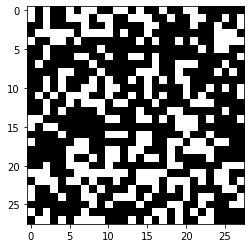

In [331]:
filterr = df_test.iloc[5].copy()

c=0
for i in agentFIndex[best]:
    if i==0:
        filterr[c]=0
    elif i==1:
        filterr[c]=255
    c=c+1

# k=0
# for i in agentFIndex[best]:
#     if k % 28==0:
#         if c==0:
#             c=1
#         else:
#             c=0
#     if c==0:
#         filterr[k]=0
#         c=1
#     else:
#         filterr[k]=255
#         c=0
#     k=k+1

 
filterimg = np.array(filterr)
filterimg = np.reshape(filterimg, (28,28))
fig = plt.figure
plt.imshow(filterimg, cmap='gray')
plt.show()

## IMAGES BEFORE AND AFTER

In [315]:
import matplotlib.pyplot as plt
image = df_test.iloc[2]
temp = np.array(image)
temp = np.reshape(temp, (28,28))

# fig = plt.figure
# plt.imshow(temp, cmap='gray')
# plt.show()

image1 = image.copy()
c=0
for i in agentFIndex[best]:
    if i==0:
        image1[c]=255
    c=c+1

temp1 = np.array(image1)
temp1 = np.reshape(temp1, (28,28))

# fig = plt.figure
# plt.imshow(temp1, cmap='gray')
# plt.show()

In [316]:
import matplotlib.pyplot as plt
image2 = df_test.iloc[8]
temp2 = np.array(image2)
temp2 = np.reshape(temp2, (28,28))

# fig = plt.figure
# plt.imshow(temp2, cmap='gray')
# plt.show()

image3 = image2.copy()
c=0
for i in agentFIndex[best]:
    if i==0:
        image3[c]=255
    c=c+1

temp3 = np.array(image3)
temp3 = np.reshape(temp3, (28,28))

# fig = plt.figure
# plt.imshow(temp3, cmap='gray')
# plt.show()

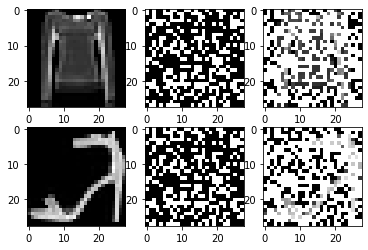

In [317]:
f, axarr = plt.subplots(2,3)
axarr[0,0].imshow(temp, cmap='gray')
axarr[0,1].imshow(filterimg, cmap='gray')
axarr[0,2].imshow(temp1, cmap='gray')

axarr[1,0].imshow(temp2, cmap='gray')
axarr[1,1].imshow(filterimg, cmap='gray')
axarr[1,2].imshow(temp3, cmap='gray')